# Heatmap
Result probability for each case and base state.

In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.quantum_info import Statevector
from sympy import factorint
from fractions import Fraction
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math
print('Import Succesfully')

Import Succesfully


In [20]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

Error routine: 50% X, 50% Z

In [21]:
def errori(circuit, n):
    epsilon = 0.5                                                      
    extracted = random.uniform(0, 1)
    position = random.randint(0, n - 1)    #to have random positions for each error

    if (extracted < epsilon):  
        circuit.x(position)   
    else:
        circuit.z(position)
    return circuit

In [22]:
def qft_rotations(circuit, n, n_max,  case):
    position = random.randint(0, n_max - 1)
    tmp = n_max - case 
    if n == 0:
        return circuit
    n -= 1    

    if n  >=  tmp:   
        errori(circuit, n_max) 
        if n == tmp: 
            circuit.id(position)    
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case)

In [23]:
def qft(circuit, n, n_max, case):
    position = random.randint(0, n - 1)
    qft_rotations(circuit, n, n_max, case)

    if case >= n + 1:
        errori(circuit, n_max)
        if case == n + 1:
            circuit.id(position)
        
    swap_registers(circuit, n)    

    if case >= n + 2:
        errori(circuit , n_max)
        if case == n + 2:
            circuit.id(position)
            
    if case >= 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [24]:
def split_circuit_by_id(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('id'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

Main:
- fixed number of qubits;
- error in random position;
- mean over reps;

In [25]:
n = 4
reps = 500

somma =  [0]*(2**n)
x = []
matrix = np.empty([n + 2, 2**n])

for line in range(n + 2):
    print(line)
    for ripetizioni in range(reps):

        case = line
        amplitudes =  [0]*(2**n) 
        position = random.randint(0, n - 1)    #all the errors in the same random position
        control = QuantumRegister(n, 'r1')
        circuit = QuantumCircuit(control)
        qft(circuit, n, n, case)  

        for subcircuit in (split_circuit_by_id(circuit)):
            circuit_left = subcircuit

        remove = []
        circuit_right = QuantumCircuit(control)
        circuit_right.data = circuit_left.data

        circuit_right.data = list(circuit_right.data)
        for i in range(len(circuit_right.data)):
            if circuit_right.data[i].operation.name == 'x' or circuit_right.data[i].operation.name == 'z':
                remove.append(i)

        for elem in sorted(remove, reverse = True):
            del circuit_right.data[elem]

        circuit_right = circuit_right.inverse()
        merge = circuit_left.compose(circuit_right)

        backend = Aer.get_backend('unitary_simulator')
        job = execute(merge, backend, shots = 8192)
        result = job.result()
        UeU = result.get_unitary(merge,3)

        for iii in range(2**n):   

            label = bin(iii).lstrip('-0b').zfill(n)
            state = Statevector.from_label(label)
            amplitudes[iii] = (((state.evolve(UeU)[label].real)**2))
            state = 0

        for l in range(2**n):
            somma[l]  = somma[l] + amplitudes[l]

    for i in range(2**n):
        somma[i] = somma[i]/reps 

    matrix[line] = somma
    somma =  [0]*(2**n)

#prova = merge
merge = 0
result = 0
UeU = 0

0


1
2
3
4
5


([<matplotlib.axis.XTick at 0x268c5f87a30>,
 [Text(0, 0, '0000'),
  Text(1, 0, '0001'),
  Text(2, 0, '0010'),
  Text(3, 0, '0011'),
  Text(4, 0, '0100'),
  Text(5, 0, '0101'),
  Text(6, 0, '0110'),
  Text(7, 0, '0111'),
  Text(8, 0, '1000'),
  Text(9, 0, '1001'),
  Text(10, 0, '1010'),
  Text(11, 0, '1011'),
  Text(12, 0, '1100'),
  Text(13, 0, '1101'),
  Text(14, 0, '1110'),
  Text(15, 0, '1111')])

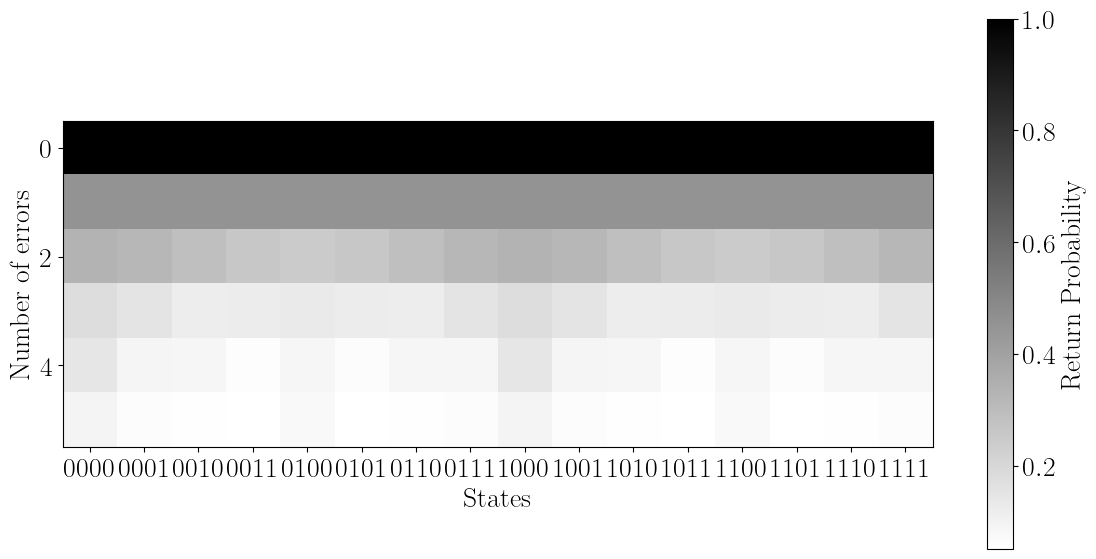

In [26]:
from matplotlib.colors import LogNorm
import pickle

params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
plt.rc('figure', figsize=(12, 6))  #18, 6 for n = 4

plt.imshow(matrix, cmap = 'binary', interpolation ='nearest')
plt.colorbar(label = 'Return Probability', location = 'right')

plt.xlabel('States')
plt.ylabel('Number of errors', rotation = 90)
plt.tight_layout()

row = []
xs = []
for i in range(2**n):
    tmp = '{0:0b}'.format(i)
    tmp_list = [int(x) for x in tmp]
    while len(tmp_list) != n:
        tmp_list.insert(0, 0)
    tmp_final = ''.join(map(str, tmp_list))
    row.append(tmp_final)
    xs.append(i)

row_labels = row
plt.xticks(xs, row_labels)

#pickle.dump(matrix, open('QFT_return_probability_heatmap.pkl', 'wb'))
#plt.savefig('QFT_return_probability_heatmap_n3Z.pdf', format = 'pdf') 


C:\Users\giuli\AppData\Local\Temp\ipykernel_22912\2689159511.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


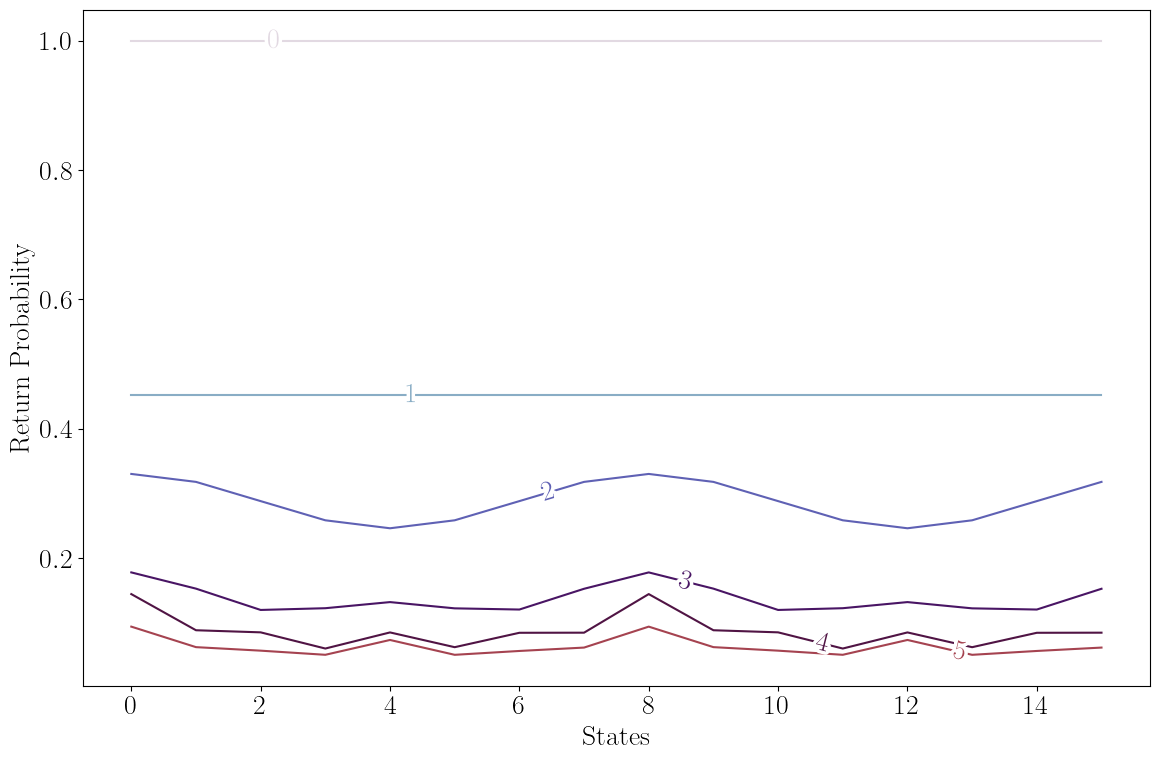

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import chi2, loglaplace
from labellines import labelLine, labelLines

X = np.linspace(0, 1, 500)
A = [0, 1, 2, 3, 4, 5]
funcs = [np.arctan]

fig, axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(12, 8))

#axes = axes.flatten()

ax = axes
#for a in A:
#    ax.plot(X, np.arctan(a * X), label=str(a))
cmap = plt.get_cmap('twilight')
for i in range(n+2):
    color = cmap(i/(n+2+1))
    ax.plot(matrix[i], label =  str(i), color = color)
      
labelLines(ax.get_lines(), zorder=2.5)  


plt.xlabel('States')
plt.ylabel('Return Probability', rotation = 90)
plt.tight_layout()

row = []
xs = []
for i in range(2**n):
    tmp = '{0:0b}'.format(i)
    tmp_list = [int(x) for x in tmp]
    while len(tmp_list) != n:
        tmp_list.insert(0, 0)
    tmp_final = ''.join(map(str, tmp_list))
    row.append(tmp_final)
    xs.append(i)

row_labels = row

#plt.xticks(xs, row_labels)
plt.savefig('QFT_return_probability_n4BIS.pdf', format = 'pdf')